In [26]:
import tensorflow as tf
import keras
from keras import backend as bk
import timeit

from scipy.integrate import ode
import math as mt
import numpy as np
import matplotlib.pyplot as plt
import random as rdm
import time
from datetime import datetime
import matplotlib.animation as animation

physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

### ANN Model

In [27]:
class Hamiltonian_model:

    def __init__(self):
        xavier=tf.keras.initializers.GlorotUniform()
        self.l1=tf.keras.layers.Dense(4,kernel_initializer=xavier,activation=tf.nn.tanh)
        self.l2=tf.keras.layers.Dense(16,kernel_initializer=xavier,activation=tf.nn.tanh)
        self.l3=tf.keras.layers.Dense(16,kernel_initializer=xavier,activation=tf.nn.tanh)
        self.out=tf.keras.layers.Dense(1,kernel_initializer=xavier)
        self.train_op = tf.keras.optimizers.Adam(learning_rate=0.001)

    # Running the model

    def run(self, X):
        #with tf.device('/cpu:0'):
        boom = self.l1(X)
        boom1 = self.l2(boom)
        boom2 = self.l3(boom1)
        boom3 = self.out(boom2)
        return boom3

    def get_loss(self, Y, X):

        with tf.GradientTape() as tape:
            tape.watch(Y)
            boom = self.l1(Y)
            boom1 = self.l2(boom)
            boom2 = self.l3(boom1)
            boom3 = self.out(boom2)
            g = tape.gradient(boom3, Y)

        loss = tf.constant(0.)
        c1=1.
        c2=8.
        c3=1.
        H_predict = boom3

        for i,j in zip(Y,g):

            loss_i = c1*(i[2]-j[1])**(2) + c2*(i[3]+j[1])**(2) + c3*(H_predict - (i[1]**(2)/2 - tf.math.cos(i[0])))**(2)
            loss = loss + loss_i

        return loss

    def get_grad(self, Y, X):
        with tf.GradientTape() as tape:
            tape.watch(self.l1.variables)
            tape.watch(self.l2.variables)
            tape.watch(self.l3.variables)
            tape.watch(self.out.variables)
            L = self.get_loss(Y, X)
            g = tape.gradient(L, [self.l1.variables[0],self.l1.variables[1],self.l2.variables[0],self.l2.variables[1],self.l3.variables[0],self.l3.variables[1],self.out.variables[0],self.out.variables[1]])
        return g

    # perform gradient descent

    def network_learn(self, Y, X):
        g = self.get_grad(Y, X)
        self.train_op.apply_gradients(zip(g, [self.l1.variables[0],self.l1.variables[1],self.l2.variables[0],self.l2.variables[1],self.l3.variables[0],self.l3.variables[1],self.out.variables[0],self.out.variables[1]]))



### Non-linear Pendulum
#### Parameters

In [28]:
N_Sample = 200
d0, t0 = [[rdm.randrange(-630, 630, 1)*0.01, rdm.randrange(-150, 150, 1)*0.01] for i in range(N_Sample)], 0
t1 = 5
dt = 0.01

def Ham(t, y):
    return [y[1], -mt.sin(y[0])]

#### Simulating the Training Data

In [29]:
start_time = datetime.now()
training_set = []

for i in range(len(d0)):
    r = ode(Ham).set_integrator('zvode', method='bdf')
    r.set_initial_value(d0[i], t0)
    trajectory = []

    while r.successful() and r.t < t1:
        r.integrate(r.t+dt)
        q = (r.integrate(r.t)[0]).real
        p = (r.integrate(r.t)[1]).real
        qdot = (r.integrate(r.t)[1]).real
        pdot = (mt.sin(r.integrate(r.t)[0])).real
        trajectory.append([q, p, qdot, pdot])


    training_set.append(trajectory)

elapsed_time = datetime.now() - start_time
print(elapsed_time)

C:\Users\valpe\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: ComplexWarning: Casting complex values to real discards the imaginary part
  import sys
C:\Users\valpe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: ComplexWarning: Casting complex values to real discards the imaginary part
  


0:00:03.198443


#### Plotting the Training Set

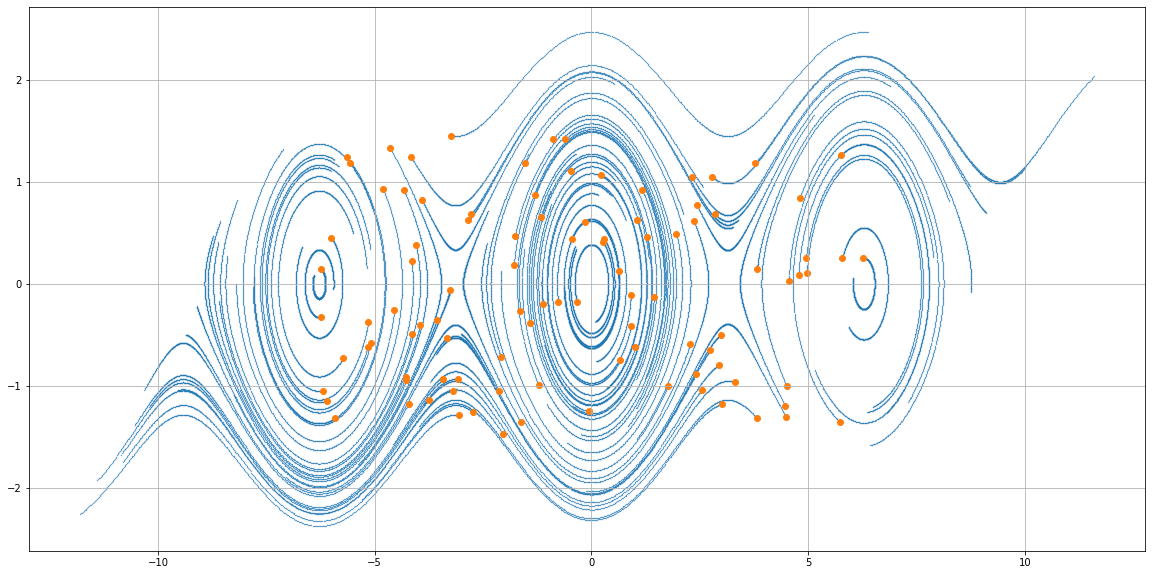

In [30]:
#q0, p0 = np.array(d0).T
q0, p0 = np.array(d0[0:100]).T


Q=[]
#for q in range(len(training_set[:])):
for q in range(100):
    QQ = []
    for qq in training_set[:][q]:
        QQ.append(qq[0])
    Q.append(QQ)
P=[]
#for p in range(len(training_set[:])):
for p in range(100):
    PP = []
    for pp in training_set[:][p]:
        PP.append(pp[1])
    P.append(PP)

fig = plt.figure(figsize=(20,10))
ax = fig.gca()
plt.scatter(Q, P, s=0.1)
plt.scatter(q0, p0)
plt.grid()
plt.show()

#### Preparing the Training set and the Model

In [31]:
train = tf.cast(tf.constant(training_set), float)
Model = Hamiltonian_model()
train[0].shape

TensorShape([501, 4])

#### Training and evaluating the model

In [35]:
start = timeit.default_timer()

#with tf.device('/cpu:0'):
    
#for i in range(len(train)):
for i in range(0, len(train)):
    Model.network_learn(train[i], train[i])
    
    if i%200==0:
        print((i/len(train))*100, '%')
        print('Loss:', tf.math.reduce_mean(Model.get_loss(train[i], train[i])).numpy())
        stop = timeit.default_timer()
        print('Time: ', stop - start)


0.0 %
Loss: 1903.5818
Time:  2.2969783000007737


#### Animated Training

75.0 %
Loss: 687.7958
Time:  48.661795100000745
75.02499999999999 %
Loss: 324.56467
Time:  102.75924410000152


KeyboardInterrupt: 

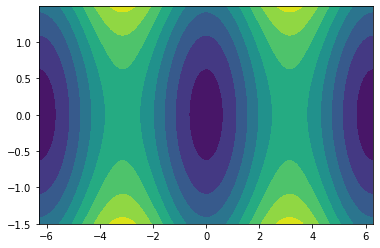

In [115]:
ims = []
start = timeit.default_timer()
fig = plt.figure()
with tf.device('/cpu:0'):
    #for i in range(len(train)):
    for i in range(16000, len(train)):
        Model.network_learn(train[i], train[i])
        if i%5==0:
            print((i/len(train))*100, '%')
            print('Loss:', tf.math.reduce_mean(Model.get_loss(train[i], train[i])).numpy())
            
            H_true = []

            for j in range(-150, 150):
                h = []
                for i in range(-150, 150):
                    h.append(Model.run(tf.constant([[i*0.01, j*0.01, 0., 0.]]))[0][0])
                H_true.append(h)
                
            x = np.arange(-6.3, 6.3, 0.01)
            y = np.arange(-1.5, 1.5, 0.01)
            z = np.array(H)
            im = plt.contourf(x,y,z_htrue)
            ims.append([im])
            
            stop = timeit.default_timer()
            print('Time: ', stop - start)

### -------------------------------------------------------------------------------
### -------------------------------------------------------------------------------
### -------------------------------------------------------------------------------

In [135]:
start = timeit.default_timer()

with tf.device('/cpu:0'):

    H = []
    for j in range(-150, 150):
        h=[]
        for i in range(-630, 630):
            h.append(Model.run(tf.constant([[i*0.01, j*0.01, 0., 0.]]))[0][0])
        H.append(h)

stop = timeit.default_timer()
print('Time: ', stop - start)

Time:  192.17238859999634


In [34]:
Model.run(tf.constant([[1.,1.,1.,2.], [1.,2.,2.,1.]]))

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[0.34820575],
       [0.25472504]], dtype=float32)>

In [136]:
H_true = []

for j in range(-150, 150):
    h = []
    for i in range(-630, 630):
        h.append((j*0.01)**(2)/2 - mt.cos(i*0.01))
    H_true.append(h)

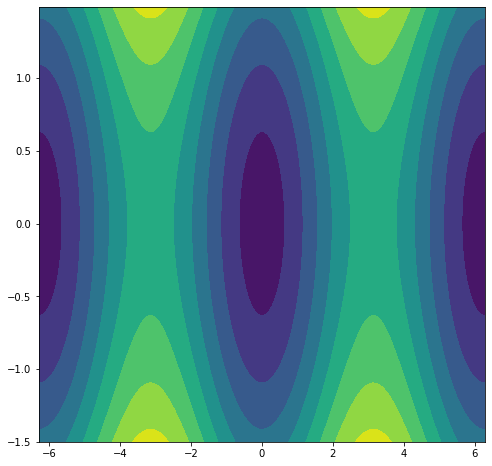

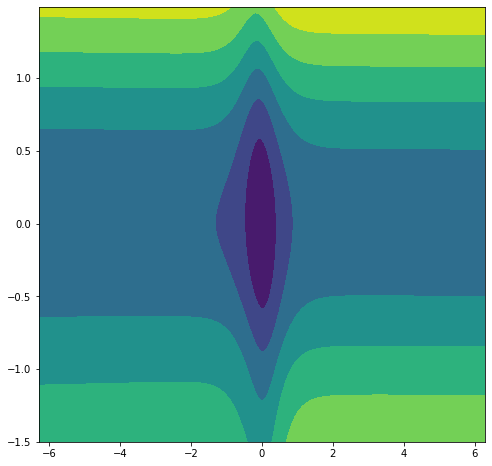

In [137]:
x = np.arange(-6.3, 6.3, 0.01)
y = np.arange(-1.5, 1.5, 0.01)

z_htrue = np.array(H_true)
z = np.array(H)
#plt.axes([-1.5,-3,3,6])

plt.figure(figsize=(8, 8))
plt.contourf(x,y,z_htrue)
#plt.axes([-1.5,-3,3,6])
plt.show()

plt.figure(figsize=(8, 8))
plt.contourf(x,y,z)
#plt.axes([-1.5,-3,3,6])
plt.show()

In [9]:
tf.config.experimental.list_logical_devices('GPU')

[LogicalDevice(name='/device:GPU:0', device_type='GPU')]

-------------------------------
-------------------------------
-------------------------------

In [14]:
#TRAINING AND PREDICTIONS
Y = tf.constant([[0.,3.,1.,0.],[0.,1.,1.,1,],[1.,2.,2.,0.],[0.,3.,1.,0.],[0.,1.,1.,1.],[1.,2.,2.,0.]]) 
My_model = my_model()
My_model.network_learn(Y, Y)

In [ ]:
My_model.get_loss()

In [45]:
My_model.network_learn(Y, Y)

In [46]:
My_model.run(tf.constant([[0.,1.,1.,1.]]))

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[1.0565188]], dtype=float32)>

----------------------------------------------------------------
----------------------------------------------------------------
----------------------------------------------------------------